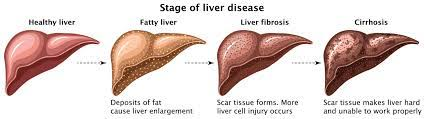

### 1. Import Packages and Read Data

In [2]:
%pip install statsmodels

import warnings
warnings.filterwarnings('ignore')
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from tensorflow.keras.layers import Conv1D, Dense, Input, MaxPooling1D, Dropout, Flatten
from tensorflow.keras.models import Sequential

from colorama import Fore, Back, Style
from yellowbrick.classifier import ROCAUC

sns.set_style('dark')


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


2022-11-17 13:50:13.682357: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
df = pd.read_csv('cirrhosis.csv')
df.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [4]:
df.describe()

,ID,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,418.000000,418.000000,418.000000,418.000000,284.000000,418.000000,310.000000,312.000000,312.000000,282.000000,407.000000,416.000000,412.000000
mean,209.500000,1917.782297,18533.351675,3.220813,369.510563,3.497440,97.648387,1982.655769,122.556346,124.702128,257.024570,10.731731,3.024272
std,120.810458,1104.672992,3815.845055,4.407506,231.944545,0.424972,85.613920,2140.388824,56.699525,65.148639,98.325585,1.022000,0.882042
min,1.000000,41.000000,9598.000000,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,1.000000
25%,105.250000,1092.750000,15644.500000,0.800000,249.500000,3.242500,41.250000,871.500000,80.600000,84.250000,188.500000,10.000000,2.000000
50%,209.500000,1730.000000,18628.000000,1.400000,309.500000,3.530000,73.000000,1259.000000,114.700000,108.000000,251.000000,10.600000,3.000000
75%,313.750000,2613.500000,21272.500000,3.400000,400.000000,3.770000,123.000000,1980.000000,151.900000,151.000000,318.000000,11.100000,4.000000
max,418.000000,4795.000000,28650.000000,28.000000,1775.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,721.000000,18.000000,4.000000


In [8]:
df['Drug'].value_counts()

D-penicillamine    158
Placebo            154
Name: Drug, dtype: int64

In [ ]:
df.shape

In [ ]:
df = df.drop('ID',axis=1)

In [ ]:
df.info()

### 2. Missing Value Treatment | Label Encoding | Prepare Data for Modeling

In [ ]:
plt.figure(figsize=(6,12))
plt.title('Missing Value by Row')
ax = sns.heatmap(df.isna().sum().to_frame(), annot = True, fmt = 'd', cmap = 'plasma')
plt.show()

In [ ]:
plt.figure(figsize=(16,10), dpi = 200)
ax = plt.axes()
sns.heatmap(df.corr(), annot = True, cmap = 'RdBu', ax = ax)
ax.set_title('Correlation MAtrix - Before Encoding and Handling Missing Data', weight = 'bold')
plt.show()

In [ ]:
#Organize binary labels into subplots to view value counts of each feature

fig, axes = plt.subplots(nrows = 2, ncols = 4, dpi =200, figsize = (24,12))

df.Status.value_counts().plot(kind = 'bar', color = 'tab:green', title = 'Status', ax =axes[0,0])
df.Drug.value_counts().plot(kind = 'bar', color = 'tab:grey', title = 'Drug', ax =axes[0,1])
df.Sex.value_counts().plot(kind = 'bar', color = 'tab:blue', title = 'Sex', ax =axes[0,2])
df.Ascites.value_counts().plot(kind = 'bar', color = 'tab:red', title = 'Ascites', ax =axes[0,3])

df.Spiders.value_counts().plot(kind='bar', color='tab:cyan', title='Spiders', ax=axes[1,0])
df.Edema.value_counts().plot(kind='bar', color='tab:purple', title='Edema', ax=axes[1,1])
df.Hepatomegaly.value_counts().plot(kind='bar', color='tab:olive', title='Hepatomegaly', ax=axes[1,2])
df.Stage.value_counts().plot(kind='bar', color='tab:orange', title='Stage', ax=axes[1,3]);

In [ ]:
# Converting Target categories into intigers 1 for Cirrhosis, 0 otherwise
df['Stage'] = np.where(df['Stage'] == 4,1,0)

In [ ]:
#Regressiion Plots for Positive Correlated Features
plt.figure(figsize= (21,12))

plt.subplot(3,1,1)
sns.regplot(x = df.Age, y=df.Stage, scatter = False, logistic = True, color = 'darkmagenta');
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False);
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False) ;
plt.xlabel('');
plt.ylabel('Cirrhosis Likelihood');
plt.setp(plt.title('Likelihood of Cirrhosis with Age'), color='darkmagenta') ;

plt.subplot(3,1,2)
sns.regplot(x=df['Prothrombin'], y=df['Stage'], scatter=False, logistic=True, color='royalblue')
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.ylabel('Cirrhosis Likelihood')
plt.setp(plt.title('Likelihood of Cirrhosis with Increased Levels of Prothrombin'), color='royalblue');

plt.subplot(3,1,3)
sns.regplot(x=df.Copper, y=df['Stage'], scatter=False, logistic=True, color='darkmagenta')
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.ylabel('Cirrhosis Likelihood')
plt.setp(plt.title('Likelihood of Cirrhosis with Increased Levels of Copper'), color='darkmagenta');

In [ ]:
#Regressiion Plots for Negative Correlated Features
plt.figure(figsize= (21,12))

plt.subplot(3,1,1)
sns.regplot(x=df['Platelets'], y=df['Stage'], scatter=False, logistic=True, color='darkmagenta')
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False);
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('');
plt.ylabel('Cirrhosis Likelihood');
plt.setp(plt.title('Likelihood of Cirrhosis with Platelet Count'), color='darkmagenta');

plt.subplot(3,1,2)
sns.regplot(x=df['Albumin'], y=df['Stage'], scatter=False, logistic=True, color='royalblue');
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False);
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('');
plt.ylabel('Cirrhosis Likelihood');
plt.setp(plt.title('Likelihood of Cirrhosis with Albumin Content'), color='royalblue');

plt.subplot(3,1,3)
sns.regplot(x=df['Cholesterol'], y=df['Stage'], scatter=False, logistic=True, color='darkmagenta')
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False);
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('');
plt.ylabel('Cirrhosis Likelihood');
plt.setp(plt.title('Likelihood of Cirrhosis with Cholesterol Content'), color='darkmagenta') ;

In [ ]:
df2 = pd.read_csv('cirrhosis.csv')
df2 = df2.drop(['ID','Age'],axis=1)

#Missing Value Treatment - Since the dataset is not very large we cannot drop any datasets instead we will be filling the numerical columns with the median and the categorical columns with the mode. This is not always the most highly accurate technique because of the inherent bias that this will create towards the handled features, but for the purposes of this dataset that will be the method that I will use.
df2 = df2[df2['Stage'].notna()]
numerical_columns = df2.select_dtypes(include = (['int64', 'float64'])).columns
categorical_columns = df2.select_dtypes(include = ('object')).columns

for c in numerical_columns:
    df2[c].fillna(df2[c].median(), inplace = True)

for c in categorical_columns:
    df2[c].fillna(df2[c].mode().values[0], inplace = True)

df2.Stage = df2.Stage.astype(int)

In [ ]:
plt.figure(figsize=(6,12))
plt.title('Missing Value by Row - Post-MVT')
ax = sns.heatmap(df2.isna().sum().to_frame(), annot = True, fmt = 'd', cmap = 'plasma')
plt.show()

In [ ]:
# Dummy Variables
df2['Sex'] = df2['Sex'].replace({'M':0, 'F':1})
df2['Ascites'] = df2['Ascites'].replace({'N':0, 'Y':1})
df2['Drug'] = df2['Drug'].replace({'D-penicillamine':0, 'Placebo':1})
df2['Hepatomegaly'] = df2['Hepatomegaly'].replace({'N':0, 'Y':1})
df2['Spiders'] = df2['Spiders'].replace({'N':0, 'Y':1})
df2['Edema'] = df2['Edema'].replace({'N':0, 'Y':1, 'S':-1})
df2['Status'] = df2['Status'].replace({'C':0, 'CL':1, 'D':-1})

In [ ]:
plt.figure(figsize = (16,10), dpi=200)
ax = plt.axes()
sns.heatmap(df2.corr(), annot = True, cmap='RdBu', ax=ax)
ax.set_title('Correlation Matrix', weight='bold')
plt.show()


**As we can see from this initial correlation matrix, Hepatomegaly has the highest correlation ratio with the stage of cirrhosis which can allow us to infer that it is a good indication of liver cirrhosis severity in the body.**

In [ ]:
plt.figure(figsize = (24,5))
sns.countplot( y = df2['Stage'], palette = 'crest', alpha = 0.8)
sns.despine(top =True, right =True, bottom = True, left =True)
plt.tick_params(axis = 'both', which = 'both', bottom = False, top = False, left = False)
plt.xlabel('Count')
plt.title('Cirrhosis Stages for Trial Participants')

In [ ]:
X = df2.drop(['Status', 'N_Days', 'Stage'], axis=1)
y = df2.pop('Stage')

In [ ]:
# Upsampling Data
sm = SMOTE(k_neighbors = 3)
X, y = sm.fit_resample(X, y)

# Scaling Data
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 23)

### 3. Perform Further Exploratory Data Analysis (EDA) to note interesting patterns in the dataset.

 **Having more samples of one class against any of the others, can result in inconsistent sampliing which will affect the accuracy. We can fix this with including more samples.**

**Per our inferences, we can see that Copper Accumulation, Age, and Prothrombin increase the likelihood of Liver Cirrhosis.**

### 4. Modeling Data

In [ ]:
#Create Accuracy Score plot for

def visualize_scores(score):

    names = ['SVM', 'Decision Tree' , 'Random Forest' , 'Logistic Regression' , 'AdaBoost' , 'KNN']

    plt.rcParams['figure.figsize'] = 20,8
    ax = sns.barplot(x =names, y = score, palette = 'crest', saturation = 1.0)
    plt.xlabel('Model Type', fontsize = 8)
    plt.ylabel('Accuracy (%)', fontsize = 8)
    plt.title('Accuracy Results from Model Training and Valiidion Tests', fontsize =30)
    plt.xticks(fontsize = 10, horizontalalignment = 'right', rotation = 6)
    plt.yticks(fontsize = 10)

    for i in ax.patches:
        width, height = i.get_width(), i.get_height()
        x,y = i.get_xy()
        ax.annotate(f'{round(height,2)}%',(x+width/2 , y +height * 1.01), ha = 'center', fontsize = 'large')
        plt.show()

In [ ]:
def trainer(X_train, y_train, X_test, y_test):

    models = [[' SVM ', SVC()],
              [' Decision Tree ', DecisionTreeClassifier()],
              [' Random Forest ', RandomForestClassifier()],
              [' Logistic Regression ', LogisticRegression(max_iter = 200)],
              [' AdaBoost ', AdaBoostClassifier()],
              [' KNN ', KNeighborsClassifier()],
        ]

    scores = []

    for model_name, model in models:

        model = model
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        cm = confusion_matrix(y_test, pred)
        scores.append(accuracy_score(y_test, model.predict(X_test)))

        print(Back.BLUE + Fore.BLACK + Style.BRIGHT + model_name)
        print(Back.RESET)
        print(cm)
        print('\n' + Fore.BLUE + 'Training Accuracy: ' + Fore.GREEN + str(round(accuracy_score(y_train, model.predict(X_train)) * 100, 2)) + '%')
        print('\n' + Fore.BLUE + 'Validation Accuracy: ' + Fore.GREEN + str(round(accuracy_score(y_test, model.predict(X_test)) * 100, 2)) + '%')
        print(Fore.GREEN + classification_report(y_test, pred))

        visualizer = ROCAUC(model)
        visualizer.fit(X_train, y_train)
        visualizer.score(X_test,y_test)
        visualizer.show()

        print('\n' + Fore.BLACK + Back.WHITE + '****************************************\n')


    return scores

In [ ]:
scores = trainer(X_train, y_train, X_test, y_test)

In [ ]:
visualize_scores(scores)

**Based on the performance shown, Random Forest is comparatively the best algorithm to apply. Considering that there are only 480 samples, I believe this accuracy is good and will be improved with further testing.**

**IDEAS ON HOW TO IMPROVE PERFORMANCE:**
- More data points for learning
- Training using an ensemble learning technique, XGBOOST

**ADDITIONAL IDEAS TO IMPROVE PEFORMANCE:**
- Using a deep learning Neural Network to process the logistic regression.

### 5. Save Model as Pickle File and Prepare to Deploy

In [ ]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
pred = model.predict(X_test)
cm = confusion_matrix(y_test, pred)
scores.append(accuracy_score(y_test, model.predict(X_test)))


In [ ]:
import pickle
pickle.dump(model, open('model.pkl', 'wb'))

In [ ]:
df2.head()

In [77]:
df2.head()

,N_Days,Status,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin
0,400,-1,0,1,1,1,1,1,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2
1,4500,0,0,1,0,1,1,0,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6
2,1012,-1,0,0,0,0,0,-1,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0
3,1925,-1,0,1,0,1,1,-1,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3
4,1504,1,1,1,0,1,1,0,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9
